In [37]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.plotly as py
#import datetime
import time
#import math
sns.set_style("whitegrid")
sns.set_color_codes("deep")

### Data Collection
Data are collected from the Aspentech IP21 process historian (see DataExtractionIP21)

In [38]:
start_time = time.time()
df = pd.read_pickle('rawdata.pkl')
elapsed_time = time.time() - start_time
print('Total loading time from pickle: %5.1f seconds.' % elapsed_time)
df.describe()

Total loading time from pickle:   0.1 seconds.


C:\Program Files\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3834: RuntimeWarning:

Invalid value encountered in percentile



,POARFQCA-17901:me,POARAIA-17903_1a:av,POARAIA-17903_3a:av,POARTC-17902:me,POARAIA-17903_2ab:av,POARTI-17912:av,POARFCA-17907:me,POARTC-17923:me,POARTCA-17931:me,POARFIA-17904:av,...,POARTCA-17929:me,POARFCA-17219:me,POARPCA-17917:me,POARFC-17918:me,POARFC-17916:me,POARTI-17935:av,POARTI-17934:av,POARTI-17933:av,POARTI-17932:av,POARFQC-17222:me
count,151475.000000,148627.000000,148625.000000,151468.000000,71651.000000,151475.000000,151237.000000,151468.000000,151475.000000,148723.000000,...,151475.000000,151237.000000,151468.000000,151015.000000,151015.000000,151475.000000,151475.000000,151475.000000,151475.000000,151475.000000
mean,23.871761,71.513382,68.307402,95.129925,97.860683,103.526511,3.097314,82.462804,198.515691,135.651187,...,58.998765,17.342544,-63.082730,1.346455,1.504830,205.210986,182.843718,183.869345,165.831276,16.716655
std,2.633070,2.512282,3.955745,1.339313,0.622579,1.198270,0.168848,2.158705,1.558089,12.468402,...,2.861413,2.039146,2.505006,0.274446,0.576327,1.653907,1.438805,1.554900,2.038795,1.932630
min,3.468945,48.740811,12.430414,91.591708,72.010378,96.731805,0.909646,39.541924,175.958551,80.193707,...,54.991944,0.000000,-72.407773,0.000000,0.000000,179.988764,160.192326,161.100939,145.663978,3.051103
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,28.730017,101.736916,78.562834,130.613648,100.000000,113.543055,3.512904,90.413389,203.653258,148.810322,...,157.287056,23.000000,-50.738568,4.140800,2.577723,216.845193,191.506107,192.079670,182.073231,19.562367


#### Create filter for steady state
* POARFQCA-17901:me (C6-feed t/h) * POARAIA-17903_1a:av (DA901 Feed C6H6 p-%) >= 15t/h

In [39]:
df_filter = pd.DataFrame()
df['BzFeed'] = df['POARFQCA-17901:me']*df['POARAIA-17903_1a:av']/100
df_filter['Filter_BzFeed_gt15'] = df['BzFeed']>=14.95
print(df_filter['Filter_BzFeed_gt15'].describe())

count     151489
unique         2
top         True
freq      134494
Name: Filter_BzFeed_gt15, dtype: object


In [40]:
def HeuristicSteadyStateFilter(df, tolerance = 1, fL = 0.8, fH = 0.2):
    xLt0 = 0 #df.iat[0,0]
    xHt0 = 0 #df.iat[0,0]
    f = []
    for row in df.itertuples():
        #print(row[0],row[1])
        if np.isnan(row[1]):
            xLt1 = 0
            xHt1 = tolerance+0.0001
        else:
            xLt1 = fL*row[1]+(1-fL)*xLt0
            xHt1 = fH*row[1]+(1-fH)*xHt0
        if (abs(xHt1-xLt1)<=tolerance):
            f.append([row[0],True,xLt1,xHt1])
        else:
            f.append([row[0],False,xLt1,xHt1])
        xLt0 = xLt1
        xHt0 = xHt1
    df_f = pd.DataFrame([x[1:] for x in f],columns=['filter','xLt','xHt'],index=[x[0] for x in f])
    return df_f

In [41]:
df_filter['HeuristicSS'] = HeuristicSteadyStateFilter(df[['BzFeed']])['filter']
print(df_filter['HeuristicSS'].describe())
#print(df_filter[df_filter['HeuristicSS']==False])
df_filter['Filter_Global'] = df_filter['HeuristicSS'] & df_filter['Filter_BzFeed_gt15']
df_filter['Filter_Global'].describe()

count     151489
unique         2
top         True
freq      148458
Name: HeuristicSS, dtype: object


count     151489
unique         2
top         True
freq      134398
Name: Filter_Global, dtype: object

### Explorative Data Analysis
#### Plot timeseries
* a timeplot with associated histogram is plotted for each tag.
* the red line represents the mean of the data ignoring the zero-values.
* the green area represents the steady state production as definied by the filter above. red is non steady-state.

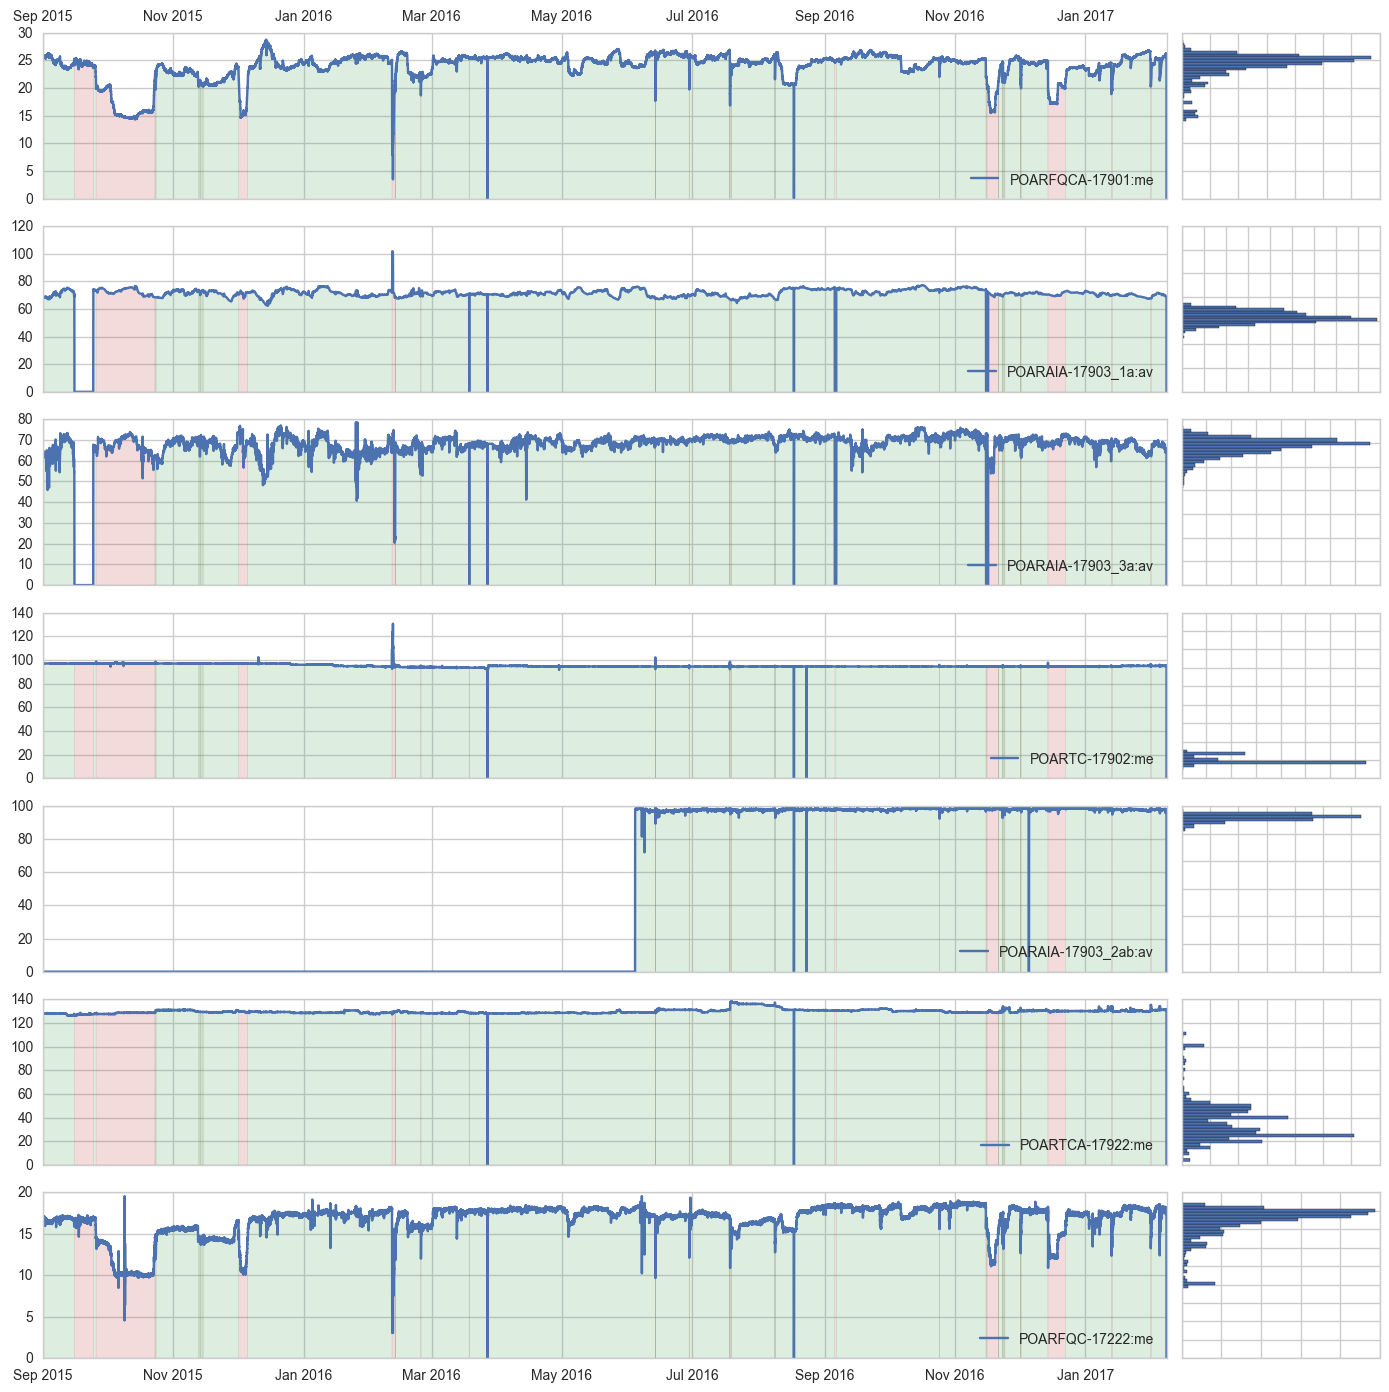

In [42]:
def plottimeseries(df,df_filter):
    numSubPlots = len(df.columns)
    f, axarr = plt.subplots(nrows=numSubPlots, ncols=2, figsize=(14,numSubPlots*2), gridspec_kw = {'width_ratios':[17, 3]})
    for i, tag in enumerate(df.columns):
        axarr[i,0].plot(df.index, df[tag].fillna(0))
        #axarr[i,0].set_xlim([0,len(df.index)])
        #axarr[i,0].axhline(y = df[tag][df[tag]!=0].mean(), color = 'r',label='Mean (excl. zeros)')
        axarr[i,0].fill_between(df.index,y1=axarr[i,0].get_ylim()[0],y2=df[tag],where=df_filter==False,color='r',alpha=0.2)
        axarr[i,0].fill_between(df.index,y1=axarr[i,0].get_ylim()[0],y2=df[tag],where=df_filter==True,color='g',alpha=0.2)
        axarr[i,0].legend(loc='lower right',ncol=2)
        if (i!=numSubPlots-1 and i!=0):
            axarr[i,0].xaxis.set_ticklabels([])
        if i==0:
            axarr[i,0].xaxis.tick_top()
        axarr[i,1].hist(df[tag].dropna(),bins=50,normed=True,orientation='horizontal')
        #axarr[i,1].axhline(y = df[tag][df[tag]!=0].mean(), color = 'r',label='Mean (excl. zeros)')
        axarr[i,1].xaxis.set_ticklabels([])
        axarr[i,1].yaxis.set_ticklabels([])
    plt.tight_layout()
        
plottimeseries(df[[0,1,2,3,4,10,62]],df_filter['Filter_Global'])

#### Plotting a heatmap of correlations
* for the first 20 variables the Pearson correlation coefficient is plotted.

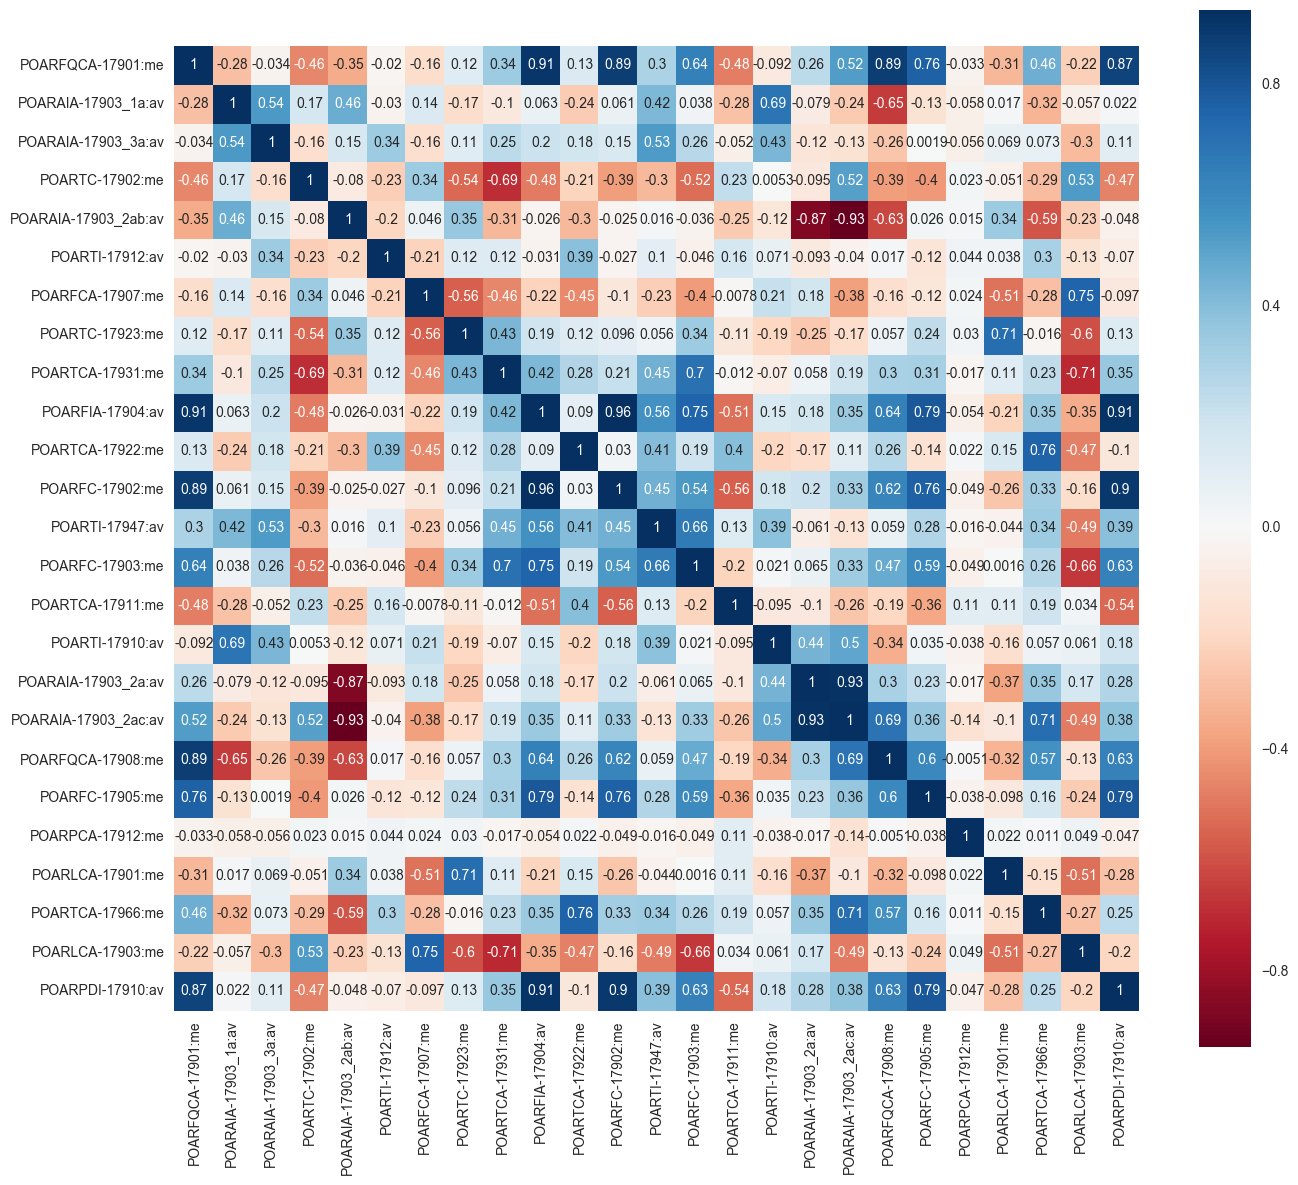

In [43]:
corrmat = df.corr()
f, ax = plt.subplots(figsize=(14, 12))
sns.heatmap(corrmat.ix[:25, :25], vmax=.6, square=True, yticklabels=True, annot=True,cmap="RdBu")
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [44]:
corrmat.values[np.tril_indices_from(corrmat)] = np.nan
s = corrmat.unstack().abs().sort_values(ascending=False,kind="quicksort")
so = s[s<1][:20]
pd.DataFrame(so)

,,0
POARTI-17907:av,POARTCA-17966:me,0.999804
POARPCA-17917:me,POARPI-17913:av,0.993982
POARTI-17920:av,POARTCA-17911:me,0.992810
POARTI-17926:av,POARPI-17913:av,0.990933
POARTI-17933:av,POARTI-17934:av,0.989433
POARPCA-17917:me,POARTI-17926:av,0.985323
POARTI-17905:av,POARTCA-17922:me,0.984414
POARTI-17915:av,POARTC-17914:me,0.977883
POARFQC-17222:me,POARFIA-17904:av,0.971756
BzFeed,POARFIA-17904:av,0.966627


#### Plotting of rolling correlations
* For 2 variables a rolling correlations is plotted. The sliding window is put to 50 data points.
* This is used to see if correlation stays stable in time.

### Data preprocessing
* Drop columns that have more then 10% missing values
* Apply the steady state filter as stated above
* Drop the rows that contain missing values

In [45]:
df = df.dropna(thresh=len(df)*0.9, axis=1)
df = df[df_filter['Filter_Global']]
df = df.dropna()


#### Performance Benchmarking
Evaluation the distribution of benzene production and target setting for estimating the economical impact.

Target: benzene production > 12t/h (cutting of the tail of the distribution)

In [69]:
target = 'POARFQC-17222:me'
val=15.1866
df1 = pd.DataFrame(index=df.index)
df1['netgain']=np.where(df[target]-val<0,-df[target]+val,0)*200
df1['cumgain']=df1['netgain'].cumsum()

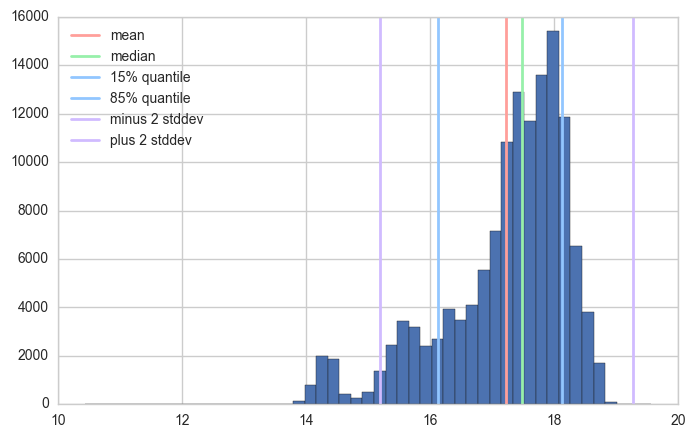

minus 2 stddev: 15.1866 - plus 2 stddev: 19.2597


In [86]:
strTagName=target
plt.figure(figsize=(8,5))
plt.hist(df[strTagName],50)
plt.axvline(x = df[strTagName].mean(), linewidth=2, color = 'r',label='mean')
plt.axvline(x = df[strTagName].median(), linewidth=2, color = 'g',label='median')
plt.axvline(x = df[strTagName].quantile(0.15), linewidth=2, color = 'b',label='15% quantile')
plt.axvline(x = df[strTagName].quantile(0.85), linewidth=2, color = 'b',label='85% quantile')
min2std = df[strTagName].mean() - 2 * df[strTagName].std()
plus2std = df[strTagName].mean() + 2 * df[strTagName].std()
plt.axvline(x = min2std, linewidth=2, color = 'm',label='minus 2 stddev')
plt.axvline(x = plus2std, linewidth=2, color = 'm',label='plus 2 stddev')
plt.legend(loc='upper left')
plt.show()
print('minus 2 stddev: {:.4f} - plus 2 stddev: {:.4f}'.format(min2std,plus2std))

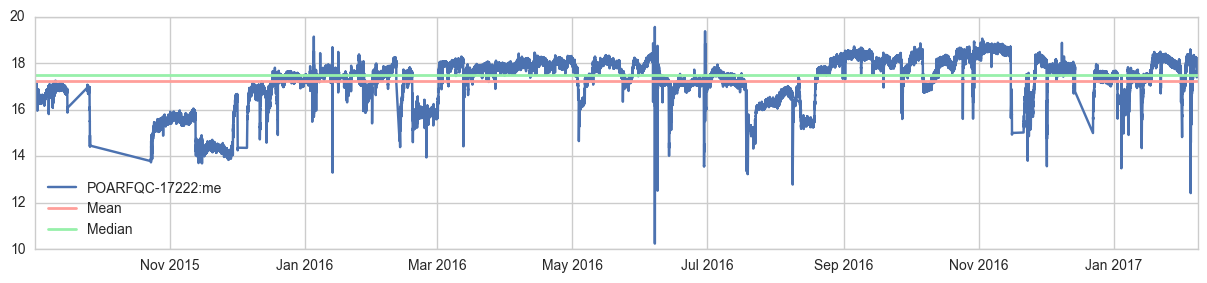

In [73]:
plt.figure(figsize=(15,3))
plt.plot(df.index,df[strTagName],label=strTagName)
plt.axhline(y = df[strTagName].mean(), linewidth=2, color = 'r',label='Mean')
plt.axhline(y = df[strTagName].median(), linewidth=2, color = 'g',label='Median')
plt.legend(loc='lower left')
plt.show()
#py.iplot_mpl(fig, strip_style = True)

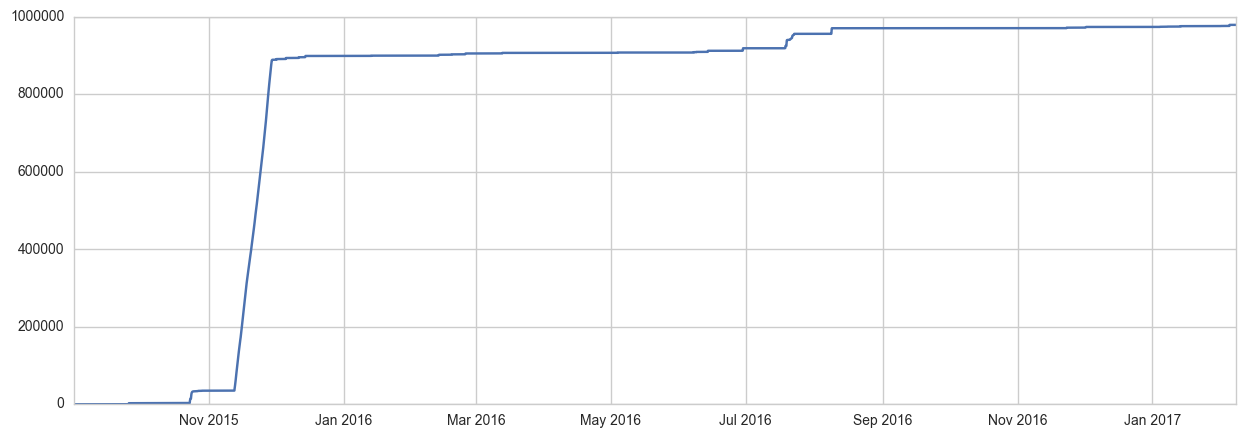

In [72]:
plt.figure(figsize=[15,5])
plt.plot(df1.index,df1['cumgain'])
plt.show()

### Data Analytics
#### Feature Clustering

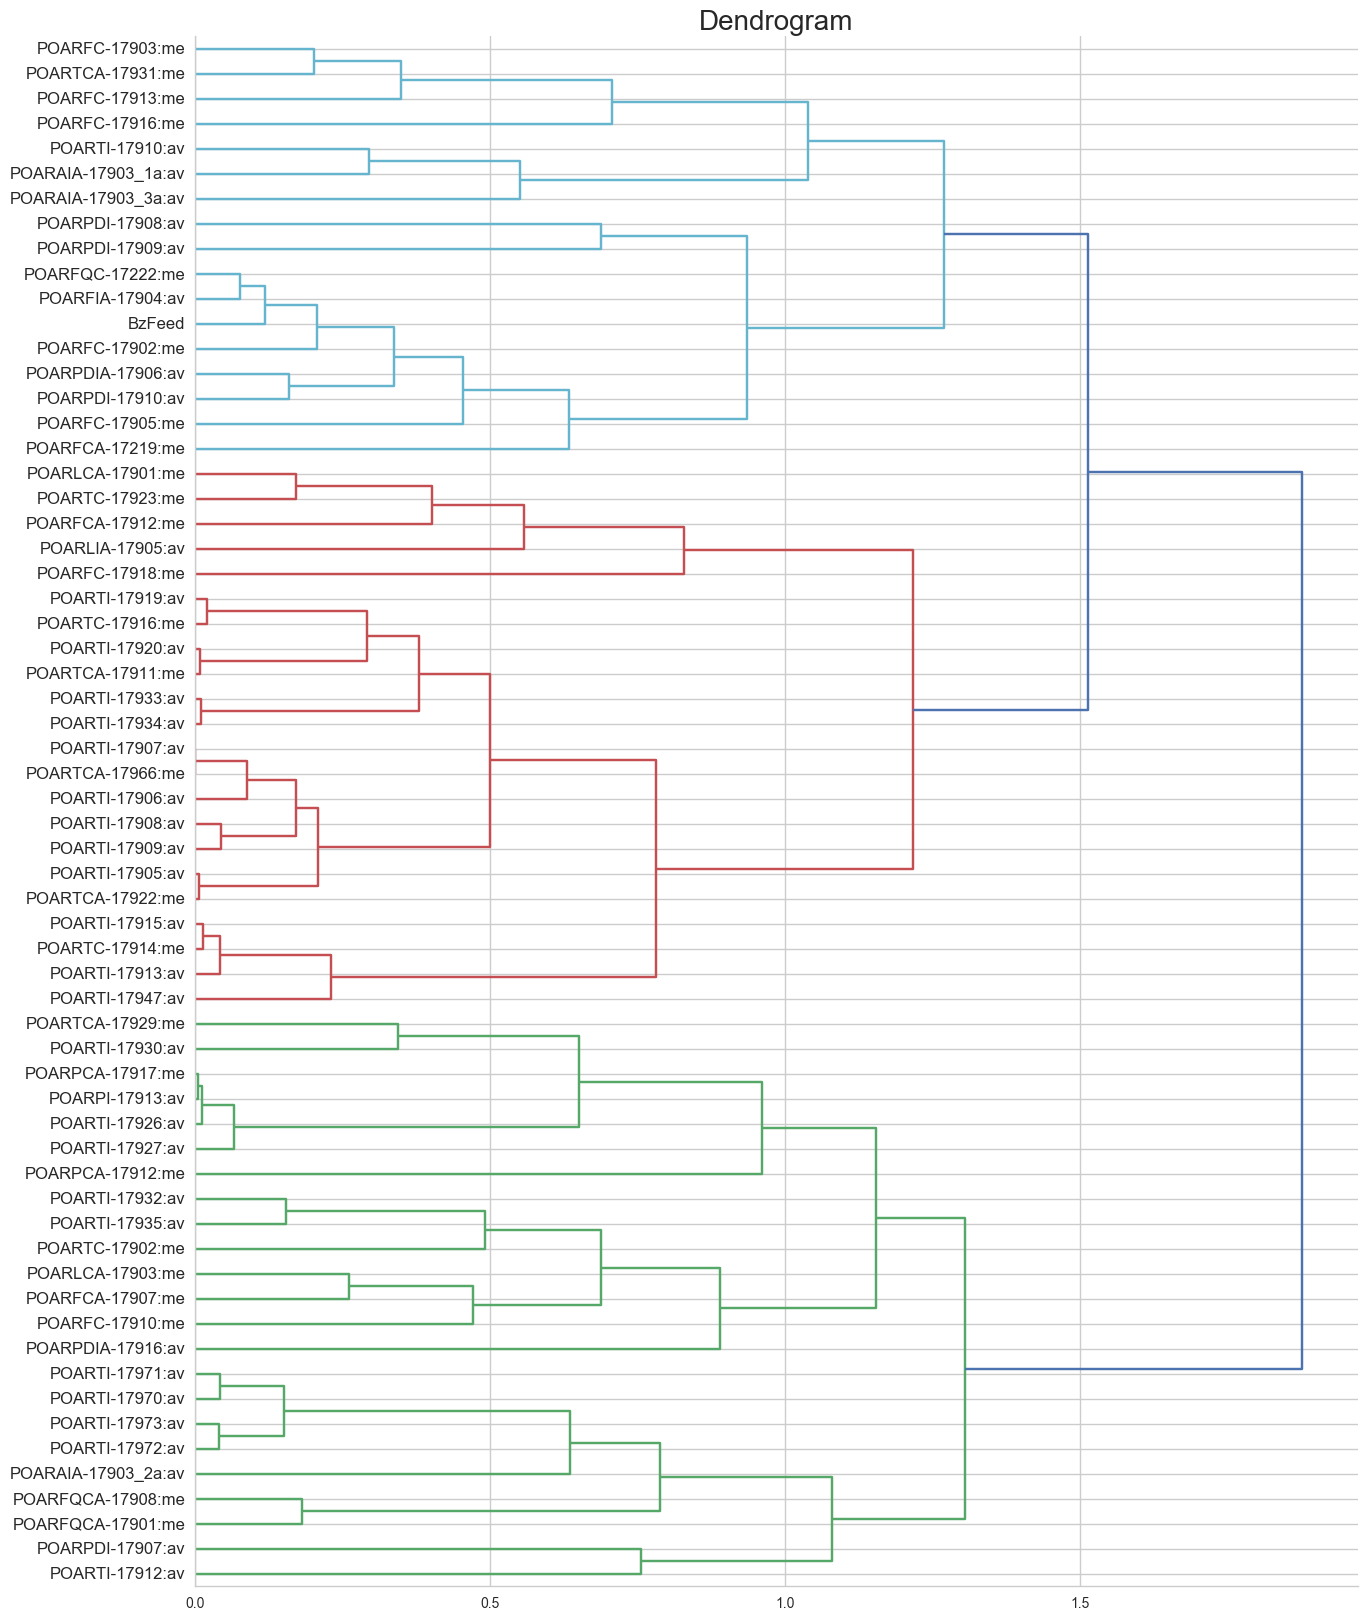

In [48]:
########################################################################
# Feature clustering
########################################################################
import scipy
from sklearn import cluster
agglo = cluster.FeatureAgglomeration(n_clusters=2, affinity='euclidean',linkage='ward')
agglo.fit(df)

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial import distance
from sklearn import preprocessing
# transform the data between min and max
#    X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
#    X_scaled = X_std * (max - min) + min
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(df)
df_normalized = pd.DataFrame(x_scaled)
features = df.columns.tolist()
df_normalized.columns = features

# create distance matrix
#distmatrix = distance.cdist(df_normalized.as_matrix().T, df_normalized.as_matrix().T)
#df_dist = pd.DataFrame(distmatrix, index = features, columns = features)

# input for linkage is either the samples*features matrix or the distance matrix
#Z = linkage(distance.squareform(df_dist.as_matrix()), 'average')
Z = linkage(df_normalized.T,metric='correlation', method='complete')

#print(Z[:20])

plt.figure(figsize=(15, 20))
#plt.figure(tight_layout=True)
dendrogram(Z,leaf_rotation=0.,leaf_font_size=12.,orientation='right',labels=df.columns)
#dendrogram(Z,leaf_rotation=90.,leaf_font_size=12.,labels=features)
plt.title("Dendrogram",fontsize=20)
#plt.xticks(rotation=90)
#plt.ylabel("Distance (1 - correlation)",fontsize=14)
sns.despine()
plt.show()


Split dataset into training and testing dataset

In [49]:
from sklearn.cross_validation import train_test_split
#from sklearn.model_selection import train_test_split # as of version 0.18.1
target = 'POARFQC-17222:me'
X=df.drop(target, axis=1)
y=df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=0)
y_train.shape

(87197,)

#### Model training
* The model is trained with the Lasso algorithm and cross-validated

In [50]:
st=time.time()
from sklearn.linear_model import LassoCV
LCV = LassoCV(eps=0.001, n_alphas=100, alphas=None, fit_intercept=True, normalize=False, 
              precompute='auto', max_iter=1000, tol=0.0001, copy_X=True, cv=None, verbose=False, 
              n_jobs=-1, positive=False, random_state=None, selection='cyclic')
LCV.fit(X_train, y_train)
print(time.time()-st)
importances = LCV.coef_
indices = np.argsort(importances)[::-1]
names = X_train.columns[indices]
abs_importances = abs(LCV.coef_)
abs_indices=np.argsort(abs_importances)[::-1]
abs_names=X_train.columns[abs_indices]
# Print the feature ranking
l = []
for f in range(X_train.shape[1]):
    d = {}
    d["feature"] = abs_names[f]
    d["abs var explained"] = abs_importances[abs_indices[f]]
    d["variance explained"] = importances[abs_indices[f]]
    #print("%d. feature %s (%f)" % (f + 1, names[f], importances[indices[f]]))
    #if f >= 19:
    #   break
    l.append(d)

df_importance = pd.DataFrame(l)
df_importance.head(10)

8.687388896942139


,abs var explained,feature,variance explained
0,0.187612,POARFQCA-17901:me,0.187612
1,0.129439,POARAIA-17903_1a:av,0.129439
2,0.107723,POARTCA-17911:me,-0.107723
3,0.105604,POARTI-17947:av,-0.105604
4,0.101230,POARPDI-17910:av,0.101230
5,0.096649,POARTC-17902:me,-0.096649
6,0.088536,POARFIA-17904:av,0.088536
7,0.080428,POARTI-17927:av,-0.080428
8,0.037817,POARAIA-17903_2a:av,-0.037817
9,0.034419,POARPCA-17917:me,0.034419


#### Model Testing
* the trained model is applied to the test data
* Model scoring is done using MAE and MSE

In [51]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
print(LCV.score(X_test,y_test))
prediction = LCV.predict(X_test)
print(prediction[:20],"\n",y_test[:20].values)

mae = mean_absolute_error(y_test,prediction)
mse = mean_squared_error(y_test,prediction)
print('Mean Absolute Error: {0:.3f}, Mean Squared Error: {1:.3f}'.format(mae,mse))

0.965769536966
[ 17.89232379  17.99696527  17.8898359   17.10467275  18.40253646
  16.7076216   17.26162903  17.76895998  17.49739105  16.51938766
  15.98136399  17.83526759  17.50680164  16.87472335  17.65121539
  18.39928397  18.14379     17.68047876  16.96741266  17.27392051] 
 [ 18.04292926  18.03357737  18.09967354  17.06092972  18.30556224
  16.6417325   17.26793957  17.97516744  17.48332252  16.40360028
  16.2988884   18.07927386  17.6013624   17.25467207  17.41201172
  18.41325417  18.18373072  17.65832233  17.20277438  17.25066118]
Mean Absolute Error: 0.127, Mean Squared Error: 0.035


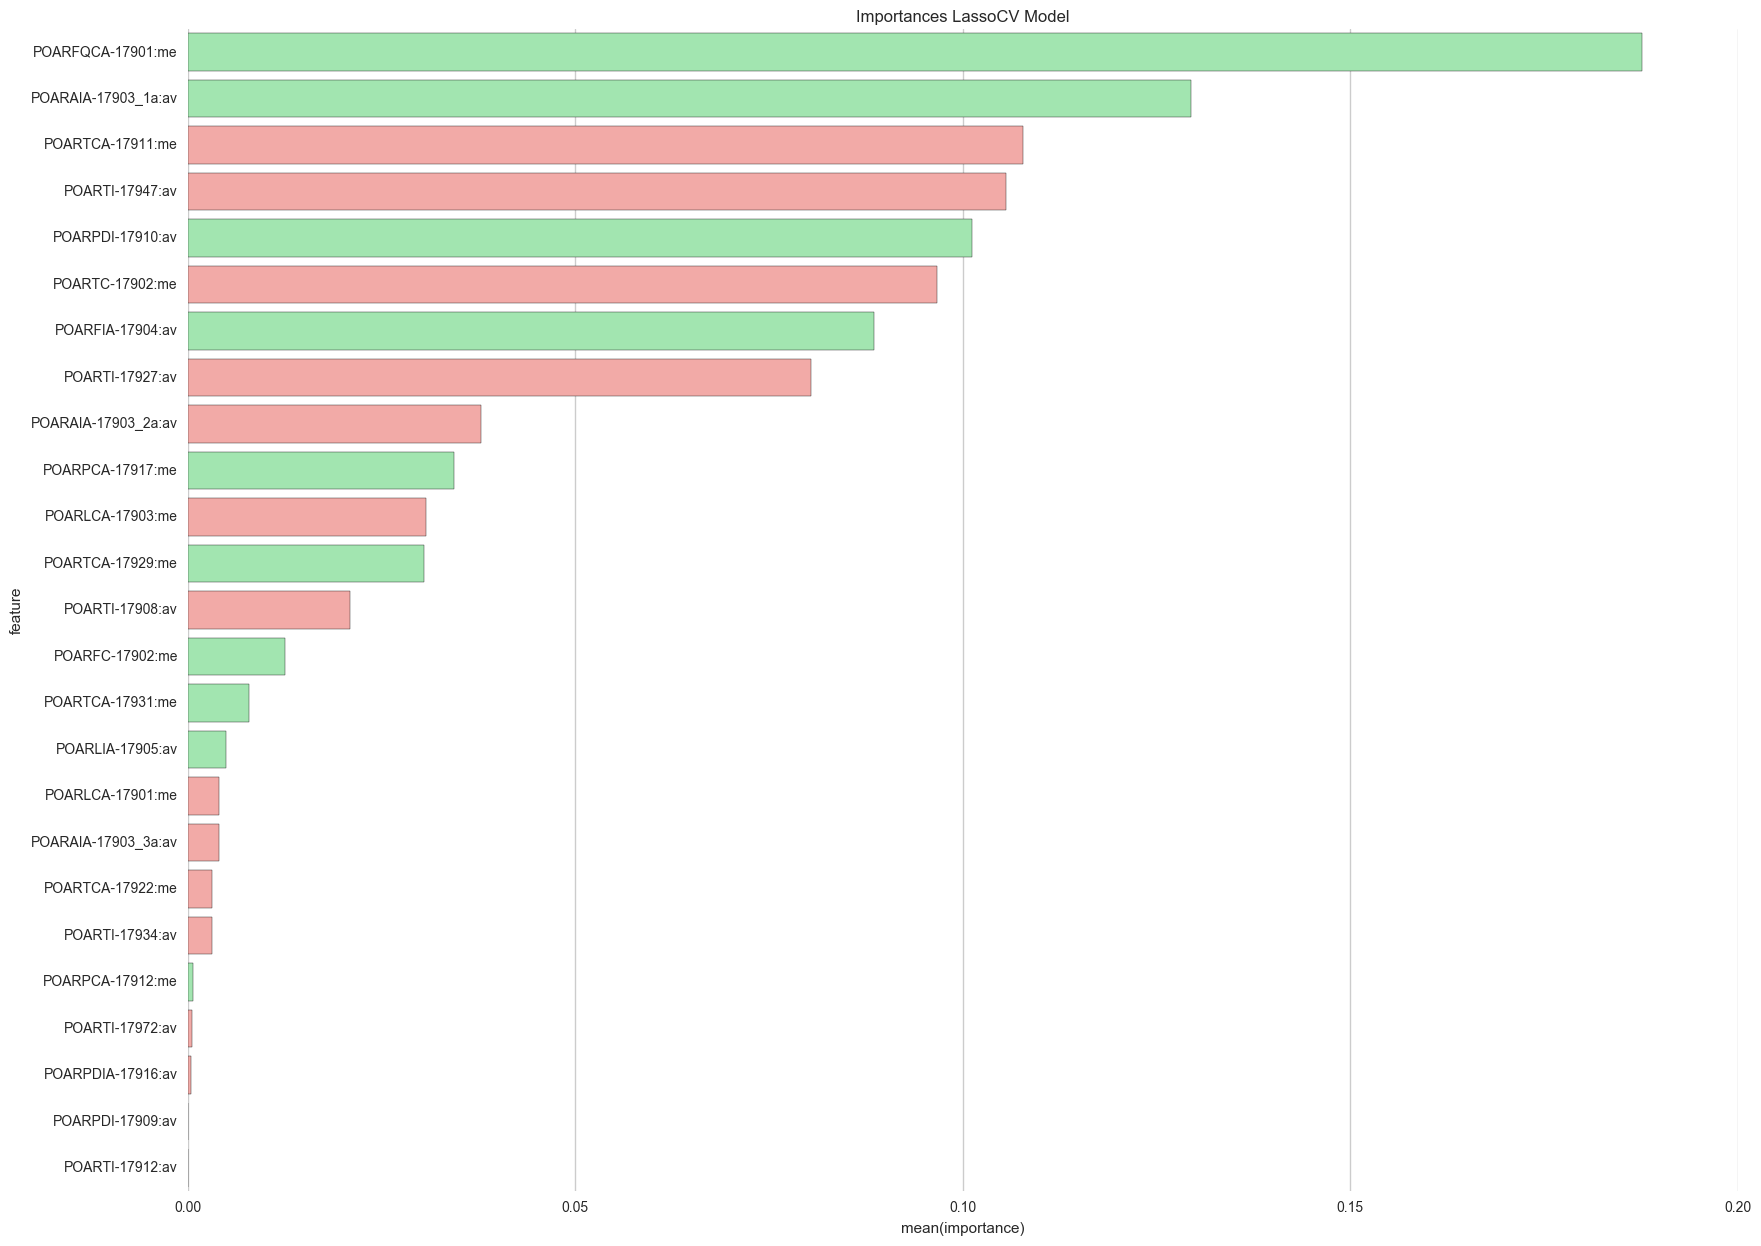

In [52]:
colorpalette = ['r' if coef < 0 else 'g' for coef in df_importance["variance explained"]]
numImp=25
df_imp = pd.DataFrame()
df_imp['feature']=abs_names[:numImp]
df_imp['importance']=abs_importances[abs_indices[:numImp]]

plt.figure(figsize=(20,15))
plt.title('Importances LassoCV Model')
sns.set_color_codes("pastel")
sns.barplot(x='importance',y='feature',data=df_imp,palette=colorpalette)
sns.despine(left=True, bottom=True)
plt.show()


In [53]:
df.describe()

,POARFQCA-17901:me,POARAIA-17903_1a:av,POARAIA-17903_3a:av,POARTC-17902:me,POARTI-17912:av,POARFCA-17907:me,POARTC-17923:me,POARTCA-17931:me,POARFIA-17904:av,POARTCA-17922:me,...,POARFCA-17219:me,POARPCA-17917:me,POARFC-17918:me,POARFC-17916:me,POARTI-17935:av,POARTI-17934:av,POARTI-17933:av,POARTI-17932:av,POARFQC-17222:me,BzFeed
count,134150.000000,134150.000000,134150.000000,134150.000000,134150.000000,134150.000000,134150.000000,134150.000000,134150.000000,134150.000000,...,134150.000000,134150.000000,134150.000000,134150.000000,134150.000000,134150.000000,134150.000000,134150.000000,134150.000000,134150.000000
mean,24.568481,71.469635,68.426401,94.956828,103.546175,3.087807,82.508270,198.680815,138.993787,129.783232,...,17.800592,-62.999353,1.344707,1.582633,205.119864,182.734505,183.763872,165.844170,17.223150,17.544226
std,1.391914,2.407990,3.667122,0.996052,1.157555,0.158688,1.859707,1.422296,6.279565,1.772441,...,1.352829,2.603771,0.277678,0.558561,1.519042,1.393694,1.517300,1.855744,1.018268,0.905264
min,20.290363,62.485561,23.089479,91.591708,99.593204,1.225268,79.775892,188.753238,110.831827,126.303128,...,0.000000,-72.407773,0.000000,0.000000,201.478481,176.611587,177.306055,160.183061,10.244034,14.950074
25%,23.811189,69.877999,66.496625,94.477490,102.824976,3.001240,81.742191,197.525385,136.818571,128.498199,...,17.411883,-65.031990,1.280996,0.994754,203.710526,181.930733,182.843390,164.492096,16.785702,17.023188
50%,24.846421,71.343647,69.231987,94.518260,103.393231,3.100263,81.989378,199.249871,140.600997,129.432351,...,17.930814,-63.133239,1.386269,1.937854,204.865100,182.686800,183.744472,165.647338,17.476202,17.972338
75%,25.543463,73.306769,70.865898,95.006357,104.175827,3.197365,82.112495,199.529968,143.497035,130.589683,...,18.465419,-61.929047,1.487492,2.031388,206.237957,183.272889,184.380788,167.353968,17.956917,18.008889
max,28.730017,77.280518,78.562834,102.312937,107.681266,3.512904,90.413389,202.481122,148.810322,138.449183,...,23.000000,-50.738568,4.140800,2.577723,213.448083,188.914500,190.182010,177.063421,19.562367,18.854918
